In [ ]:
import logging
from importlib import reload
import os

import torch
import torch.nn as nn
import cv2
import numpy as np
from tqdm import trange

from pathlib import Path

from marmopose.version import __version__ as marmopose_version
from marmopose.config import Config
from marmopose.processing.prediction import Predictor
import matplotlib.pyplot as plt
import matplotlib.patches as patches


logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(name)s - %(message)s')
logger = logging.getLogger(__name__)

logger.info(f'MarmoPose version: {marmopose_version}')

2026-01-14 10:53:58,110 - INFO - __main__ - MarmoPose version: 1.2.2


In [32]:
config_path = '../configs/default.yaml'

config = Config(
    config_path=config_path,
    
    n_tracks=1,
    project='../demos/test',
    det_model= '../data/detection_model_family_finetune',
    pose_model= '../data/pose_model_finetune',

)
print(config.sub_directory)


config_base = Config(
    config_path=config_path,
    
    n_tracks=1,
    project='../demos/test',
)
print(config.sub_directory)

2026-01-14 11:23:58,794 - INFO - marmopose.config - *** Overriding config *** | n_tracks: 2 -> 1
2026-01-14 11:23:58,795 - INFO - marmopose.config - *** Overriding config *** | project: ../demos/single -> ../demos/test
2026-01-14 11:23:58,795 - INFO - marmopose.config - *** Overriding config *** | det_model: ../models/detection_model -> ../data/detection_model_family_finetune
2026-01-14 11:23:58,795 - INFO - marmopose.config - *** Overriding config *** | pose_model: ../models/pose_model -> ../data/pose_model_finetune
2026-01-14 11:23:58,800 - INFO - marmopose.config - *** Overriding config *** | n_tracks: 2 -> 1
2026-01-14 11:23:58,800 - INFO - marmopose.config - *** Overriding config *** | project: ../demos/single -> ../demos/test


{'calibration': '../demos/test/calibration', 'points_2d': '../demos/test/points_2d', 'points_3d': '../demos/test/points_3d', 'videos_raw': '../demos/test/videos_raw', 'videos_labeled_2d': '../demos/test/videos_labeled_2d', 'videos_labeled_3d': '../demos/test/videos_labeled_3d'}
{'calibration': '../demos/test/calibration', 'points_2d': '../demos/test/points_2d', 'points_3d': '../demos/test/points_3d', 'videos_raw': '../demos/test/videos_raw', 'videos_labeled_2d': '../demos/test/videos_labeled_2d', 'videos_labeled_3d': '../demos/test/videos_labeled_3d'}


In [33]:
predictor = Predictor(config, batch_size=4)
predictor_base = Predictor(config_base, batch_size=4)


2026-01-14 11:23:59,687 - INFO - marmopose.processing.prediction - Predictor device: cuda | batch size: 4
2026-01-14 11:23:59,689 - INFO - marmopose.processing.prediction - Load detection model config from ../data/detection_model_family_finetune/detection_config.py
2026-01-14 11:23:59,689 - INFO - marmopose.processing.prediction - Load detection model checkpoint from ../data/detection_model_family_finetune/best_coco_bbox_mAP_epoch_300.pth


Loads checkpoint by local backend from path: ../data/detection_model_family_finetune/best_coco_bbox_mAP_epoch_300.pth


2026-01-14 11:24:00,638 - INFO - marmopose.processing.prediction - Load pose model config from ../data/pose_model_finetune/pose_config.py
2026-01-14 11:24:00,639 - INFO - marmopose.processing.prediction - Load pose model checkpoint from ../data/pose_model_finetune/best_coco_AP_epoch_310.pth
2026-01-14 11:24:00,943 - INFO - marmopose.processing.prediction - Predictor device: cuda | batch size: 4
2026-01-14 11:24:00,945 - INFO - marmopose.processing.prediction - Load detection model config from ../models/detection_model/config.py
2026-01-14 11:24:00,945 - INFO - marmopose.processing.prediction - Load detection model checkpoint from ../models/detection_model/best.pth


Loads checkpoint by local backend from path: ../data/pose_model_finetune/best_coco_AP_epoch_310.pth


2026-01-14 11:24:01,564 - INFO - marmopose.processing.prediction - Load pose model config from ../models/pose_model/config.py
2026-01-14 11:24:01,565 - INFO - marmopose.processing.prediction - Load pose model checkpoint from ../models/pose_model/best.pth


Loads checkpoint by local backend from path: ../models/detection_model/best.pth
Loads checkpoint by local backend from path: ../models/pose_model/best.pth


In [42]:
import json
dataset_dir = '../../Sleap/TrainingData/marmoset_family/'
with open(os.path.join(dataset_dir,'annotations/test.json'), 'r') as f:
    test_json = json.load(f)
img_ids = [ann['image_id'] for ann in test_json['annotations']]
images = [cv2.imread(os.path.join(dataset_dir,'images',img['file_name'])) for img in test_json['images'] if img['id'] in img_ids]
gt_keypoints = np.array([ann['keypoints'] for ann in test_json['annotations']]).reshape((-1,1,16,3))
gt_bboxes = np.array([ann['bbox'] for ann in test_json['annotations']]).reshape((-1,1,4))


In [ ]:
points_with_score_2d_finetuned, bboxes_finetuned = predictor.predict_image_batch(images)
points_with_score_2d_base, bboxes_base = predictor_base.predict_image_batch(images)
points_with_score_2d_base[:,:,:,2] /= np.nanmax(points_with_score_2d_base[:,:,:,2])
points_with_score_2d_finetuned[:,:,:,2] /= np.nanmax(points_with_score_2d_finetuned[:,:,:,2])


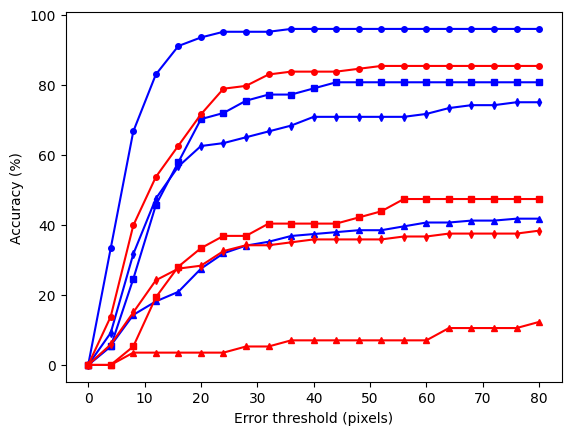

In [158]:
thresholds = np.arange(0,81,4)
non_labelled_head_gt = np.sum(gt_keypoints[:,:,:3,2] == 0)
labelled_head_gt = gt_keypoints[:,:,:3,2].size - non_labelled_head_gt
non_labelled_body_gt = np.sum(gt_keypoints[:,:,[3,8],2] == 0)
labelled_body_gt = gt_keypoints[:,:,[3,8],2].size - non_labelled_body_gt
non_labelled_limbs_gt = np.sum(gt_keypoints[:,:,np.r_[4:8,9:13],2] == 0)
labelled_limbs_gt = gt_keypoints[:,:,np.r_[4:8,9:13],2].size - non_labelled_limbs_gt
non_labelled_tail_gt = np.sum(gt_keypoints[:,:,13:,2] == 0)
labelled_tail_gt = gt_keypoints[:,:,13:,2].size - non_labelled_tail_gt

error_head_finetuned = (points_with_score_2d_finetuned[:,:,:3,:2] - gt_keypoints[:,:,:3,:2])
error_head_finetuned = np.sqrt(np.einsum('ijkl, ijkl -> ik',error_head_finetuned,error_head_finetuned))
perc_head_finetuned = [100 * np.sum(error_head_finetuned < thresh)/labelled_head_gt for thresh in thresholds]

error_body_finetuned = (points_with_score_2d_finetuned[:,:,[3,8],:2] - gt_keypoints[:,:,[3,8],:2])
error_body_finetuned = np.sqrt(np.einsum('ijkl, ijkl -> ik',error_body_finetuned,error_body_finetuned))
perc_body_finetuned = [100 * np.sum(error_body_finetuned < thresh)/labelled_body_gt for thresh in thresholds]

error_limbs_finetuned = (points_with_score_2d_finetuned[:,:,np.r_[4:8,9:13],:2] - gt_keypoints[:,:,np.r_[4:8,9:13],:2])
error_limbs_finetuned = np.sqrt(np.einsum('ijkl, ijkl -> ik',error_limbs_finetuned,error_limbs_finetuned))
perc_limbs_finetuned = [100 * np.sum(error_limbs_finetuned < thresh)/labelled_limbs_gt for thresh in thresholds]

error_tail_finetuned = (points_with_score_2d_finetuned[:,:,13:,:2] - gt_keypoints[:,:,13:,:2])
error_tail_finetuned = np.sqrt(np.einsum('ijkl, ijkl -> ik',error_tail_finetuned,error_tail_finetuned))
perc_tail_finetuned = [100 * np.sum(error_tail_finetuned < thresh)/labelled_tail_gt for thresh in thresholds]


error_head_base = (points_with_score_2d_base[:,:,:3,:2] - gt_keypoints[:,:,:3,:2])
error_head_base = np.sqrt(np.einsum('ijkl, ijkl -> ik',error_head_base,error_head_base))
perc_head_base = [100 * np.sum(error_head_base < thresh)/labelled_head_gt for thresh in thresholds]

error_body_base = (points_with_score_2d_base[:,:,[3,8],:2] - gt_keypoints[:,:,[3,8],:2])
error_body_base = np.sqrt(np.einsum('ijkl, ijkl -> ik',error_body_base,error_body_base))
perc_body_base = [100 * np.sum(error_body_base < thresh)/labelled_body_gt for thresh in thresholds]

error_limbs_base = (points_with_score_2d_base[:,:,np.r_[4:8,9:13],:2] - gt_keypoints[:,:,np.r_[4:8,9:13],:2])
error_limbs_base = np.sqrt(np.einsum('ijkl, ijkl -> ik',error_limbs_base,error_limbs_base))
perc_limbs_base = [100 * np.sum(error_limbs_base < thresh)/labelled_body_gt for thresh in thresholds]

error_tail_base = (points_with_score_2d_base[:,:,13:,:2] - gt_keypoints[:,:,13:,:2])
error_tail_base = np.sqrt(np.einsum('ijkl, ijkl -> ik',error_tail_base,error_tail_base))
perc_tail_base = [100 * np.sum(error_tail_base < thresh)/labelled_tail_gt for thresh in thresholds]

plt.plot(thresholds,perc_head_finetuned,c='b',marker = 'o',ms=4)
plt.plot(thresholds,perc_body_finetuned,c='b',marker = 's',ms=4)
plt.plot(thresholds,perc_limbs_finetuned,c='b',marker = '^',ms=4)
plt.plot(thresholds,perc_tail_finetuned,c='b',marker = 'd',ms=4)

plt.plot(thresholds,perc_head_base,c='r',marker = 'o',ms=4)
plt.plot(thresholds,perc_body_base,c='r',marker = 's',ms=4)
plt.plot(thresholds,perc_limbs_base,c='r',marker = '^',ms=4)
plt.plot(thresholds,perc_tail_base,c='r',marker = 'd',ms=4)
plt.xlabel('Error threshold (pixels)')
plt.ylabel('Accuracy (%)')
plt.show()

In [159]:
# print(points_with_score_2d_finetuned.shape)
# print(bboxes_finetuned.shape)
# print(points_with_score_2d_base.shape)
# print(bboxes_base.shape)
# print(gt_keypoints.shape)
# print(gt_bboxes.shape)
# print(np.nansum((gt_bboxes - bboxes_base)**2)/(gt_keypoints.shape[0] * gt_keypoints.shape[2]))
# print(np.nansum((gt_bboxes - bboxes_finetuned)**2)/(gt_keypoints.shape[0] * gt_keypoints.shape[2]))
# for i, image in enumerate(images):
#     fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
#     axes[0].set_title(img_ids[i])
#     axes[0].imshow(image[:,:,[2,1,0]])
#     axes[1].imshow(image[:,:,[2,1,0]])
#     rect = patches.Rectangle(
#         (gt_bboxes[i,0,0], gt_bboxes[i,0,1]), gt_bboxes[i,0,2], gt_bboxes[i,0,3],
#         linewidth=1, edgecolor='g', facecolor='none'
#     )
#     axes[0].add_patch(rect)
#     axes[0].scatter(gt_keypoints[i,0,:,0],gt_keypoints[i,0,:,1],alpha = gt_keypoints[i,0,:,2]/2,c='g',s = 1)
#     base_nans = np.isnan(points_with_score_2d_base[i,0,:,2])
#     if not np.sum(base_nans) == 16:
#         axes[0].scatter(points_with_score_2d_base[i,0,~base_nans,0],points_with_score_2d_base[i,0,~base_nans,1],c='r',s = points_with_score_2d_base[i,0,~base_nans,2])
#     rect = patches.Rectangle(
#         (gt_bboxes[i,0,0], gt_bboxes[i,0,1]), gt_bboxes[i,0,2], gt_bboxes[i,0,3],
#         linewidth=1, edgecolor='g', facecolor='none'
#     )
    
#     axes[1].add_patch(rect)
#     axes[1].scatter(gt_keypoints[i,0,:,0],gt_keypoints[i,0,:,1],alpha = gt_keypoints[i,0,:,2]/2,c='g',s = 1)
#     finetuned_nans = np.isnan(points_with_score_2d_finetuned[i,0,:,2])
#     axes[1].scatter(points_with_score_2d_finetuned[i,0,~finetuned_nans,0],points_with_score_2d_finetuned[i,0,~finetuned_nans,1],c='b',s = points_with_score_2d_finetuned[i,0,~finetuned_nans,2])
#     rect = patches.Rectangle(
#         (bboxes_base[i,0,0], bboxes_base[i,0,1]), bboxes_base[i,0,2]-bboxes_base[i,0,0], bboxes_base[i,0,3]-bboxes_base[i,0,1],
#         linewidth=1, edgecolor='r', facecolor='none'
#     )
#     axes[0].add_patch(rect)
#     rect = patches.Rectangle(
#         (bboxes_finetuned[i,0,0], bboxes_finetuned[i,0,1]), bboxes_finetuned[i,0,2]-bboxes_finetuned[i,0,0], bboxes_finetuned[i,0,3]-bboxes_finetuned[i,0,1],
#         linewidth=1, edgecolor='b', facecolor='none'
#     )
#     axes[1].add_patch(rect)

#     axes[0].axis('off')
#     axes[1].axis('off')
#     fig.show()




In [109]:
import json
dataset_dir = '../../Sleap/TrainingData/marmoset_family/'
with open(os.path.join(dataset_dir,'annotations/train.json'), 'r') as f:
    train_json = json.load(f)
img_ids = [ann['image_id'] for ann in train_json['annotations']]
images = [cv2.imread(os.path.join(dataset_dir,'images',img['file_name'])) for img in train_json['images'] if img['id'] in img_ids]
gt_keypoints_train = np.array([ann['keypoints'] for ann in train_json['annotations']]).reshape((-1,1,16,3))
gt_bboxes_train = np.array([ann['bbox'] for ann in train_json['annotations']]).reshape((-1,1,4))


In [110]:
points_with_score_2d_finetuned_train, bboxes_finetuned_train = predictor.predict_image_batch(images)
points_with_score_2d_base_train, bboxes_base_train = predictor_base.predict_image_batch(images)
points_with_score_2d_base_train[:,:,:,2] /= np.nanmax(points_with_score_2d_base_train[:,:,:,2])
points_with_score_2d_finetuned_train[:,:,:,2] /= np.nanmax(points_with_score_2d_finetuned_train[:,:,:,2])


In [160]:
# for i, image in enumerate(images):
#     fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
#     axes[0].set_title(img_ids[i])
#     axes[0].imshow(image[:,:,[2,1,0]])
#     axes[1].imshow(image[:,:,[2,1,0]])
#     rect = patches.Rectangle(
#         (gt_bboxes_train[i,0,0], gt_bboxes_train[i,0,1]), gt_bboxes_train[i,0,2], gt_bboxes_train[i,0,3],
#         linewidth=1, edgecolor='g', facecolor='none'
#     )
#     axes[0].add_patch(rect)
#     axes[0].scatter(gt_keypoints_train[i,0,:,0],gt_keypoints_train[i,0,:,1],alpha = gt_keypoints_train[i,0,:,2]/2,c='g',s = 1)
#     base_nans = np.isnan(points_with_score_2d_base_train[i,0,:,2])
#     if not np.sum(base_nans) == 16:
#         axes[0].scatter(points_with_score_2d_base_train[i,0,~base_nans,0],points_with_score_2d_base_train[i,0,~base_nans,1],c='r',s = points_with_score_2d_base_train[i,0,~base_nans,2])
#     rect = patches.Rectangle(
#         (gt_bboxes_train[i,0,0], gt_bboxes_train[i,0,1]), gt_bboxes_train[i,0,2], gt_bboxes_train[i,0,3],
#         linewidth=1, edgecolor='g', facecolor='none'
#     )
    
#     axes[1].add_patch(rect)
#     axes[1].scatter(gt_keypoints_train[i,0,:,0],gt_keypoints_train[i,0,:,1],alpha = gt_keypoints_train[i,0,:,2]/2,c='g',s = 1)
#     finetuned_nans = np.isnan(points_with_score_2d_finetuned_train[i,0,:,2])
#     axes[1].scatter(points_with_score_2d_finetuned_train[i,0,~finetuned_nans,0],points_with_score_2d_finetuned_train[i,0,~finetuned_nans,1],c='b',s = points_with_score_2d_finetuned_train[i,0,~finetuned_nans,2])
#     rect = patches.Rectangle(
#         (bboxes_base_train[i,0,0], bboxes_base_train[i,0,1]), bboxes_base_train[i,0,2]-bboxes_base_train[i,0,0], bboxes_base_train[i,0,3]-bboxes_base_train[i,0,1],
#         linewidth=1, edgecolor='r', facecolor='none'
#     )
#     axes[0].add_patch(rect)
#     rect = patches.Rectangle(
#         (bboxes_finetuned_train[i,0,0], bboxes_finetuned_train[i,0,1]), bboxes_finetuned_train[i,0,2]-bboxes_finetuned_train[i,0,0], bboxes_finetuned_train[i,0,3]-bboxes_finetuned_train[i,0,1],
#         linewidth=1, edgecolor='b', facecolor='none'
#     )
#     axes[1].add_patch(rect)

#     axes[0].axis('off')
#     axes[1].axis('off')
#     fig.show()


